# Data Exploration / Testing Algorithms

Dataset: https://snap.stanford.edu/data/soc-RedditHyperlinks.html

Political subreddits list: https://github.com/valentinhofmann/politosphere/blob/main/data/subreddits.txt


## Dataset information
- **SOURCE_SUBREDDIT**: the subreddit where the link originates
- **TARGET_SUBREDDIT**: the subreddit where the link ends
- **POST_ID**: the post in the source subreddit that starts the link
- **TIMESTAMP**: time time of the post
- **POST_LABEL**: label indicating if the source post is explicitly negative towards the target post. The value is -1 if the source is negative towards the target, and 1 if it is neutral or positive. The label is created using crowd-sourcing and training a text based classifier, and is better than simple sentiment analysis of the posts. Please see the reference paper for details.
- **POST_PROPERTIES**: a vector representing the text properties of the source post, listed as a list of comma separated numbers. The vector elements are the following:
1. Number of characters
2. Number of characters without counting white space
3. Fraction of alphabetical characters
4. Fraction of digits
5. Fraction of uppercase characters
6. Fraction of white spaces
7. Fraction of special characters, such as comma, exclamation mark, etc.
8. Number of words
9. Number of unique works
10. Number of long words (at least 6 characters)
11. Average word length
12. Number of unique stopwords
13. Fraction of stopwords
14. Number of sentences
15. Number of long sentences (at least 10 words)
16. Average number of characters per sentence
17. Average number of words per sentence
18. Automated readability index
19. Positive sentiment calculated by VADER
20. Negative sentiment calculated by VADER
21. Compound sentiment calculated by VADER

22-86. LIWC Variables

In [26]:
import pandas as pd
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt

In [27]:
# load the data
network_file = "data/soc-redditHyperlinks-body.tsv"
political_file = "data/subreddits.txt"

df_full = pd.read_csv(network_file, sep="\t")

In [28]:
import re

# Read in political subs
with open('data/subreddits.txt', 'r') as f:
    political_subs = f.readlines()
political_subs = [sub.rstrip('\n') for sub in political_subs]

regex = re.compile(r'(politic|trump|biden|democrat|republican|liberal|conservative|progressive|socialist|libertarian|election|vote|campaign|maga|antifa|obama|sanders|rights|justice|reform|policy|government|senate|president)', re.IGNORECASE)
dynamic_political_subs = [sub for sub in df_full["SOURCE_SUBREDDIT"].unique() if regex.search(sub)]
political_subs.extend(dynamic_political_subs)
political_subs = list(set(political_subs))

source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)

# keep only rows where both source and target are political
df = df_full[source_is_political & target_is_political]



In [29]:
df.to_csv("data/filtered_network.csv", index=False)

In [30]:
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# create graph
G = nx.from_pandas_edgelist(edgelist_df, source=source, target=target, create_using=nx.DiGraph(),edge_attr="count")
# convert to adjacency matrix
adj_matrix = nx.to_pandas_adjacency(G, weight="count")

In [31]:
adj_matrix

,metaconservative,conservative,libertarian,libertariancopypasta,politicaldiscussion,communism101,communism,mensrightsmeta,mensrights,politics,...,shitlibertariansay,neoliberal,theredpillright,holocaust,bernie_sanders,georgism,politicalrevolutionpa,modelussenate,modelsenateenvirocom,modelsenatefinancecom
metaconservative,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
conservative,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
libertarian,0.0,6.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,16.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
libertariancopypasta,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
politicaldiscussion,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
georgism,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
politicalrevolutionpa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
modelussenate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
modelsenateenvirocom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Convert to undirected graph for Louvain method
G_undirected = G.to_undirected()

# Compute the best partition
partition = community_louvain.best_partition(G_undirected, weight='count')

nx.set_node_attributes(G, partition, 'community')

# calculate node sizes based on degree
node_sizes = [100 + 10 * G_undirected.degree(node) for node in G_undirected.nodes()]

# Select the top three nodes with the highest degree in each community for labeling
community_labels = {}
for community in set(partition.values()):
    community_nodes = [node for node in partition if partition[node] == community]
    
    top_nodes = sorted(community_nodes, key=lambda node: G_undirected.degree(node), reverse=True)[:3]
    
    for node in top_nodes:
        community_labels[node] = node  

print("Number of communities detected:", len(set(partition.values())))
print("Sample of nodes and their communities:", list(partition.items())[:10])

# Plot the communities with node size based on degree
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G_undirected)
colors = [partition[node] for node in G_undirected.nodes()]

# Draw the graph with variable node sizes and selective labels
nx.draw(G_undirected, pos, node_color=colors, node_size=node_sizes, labels=community_labels, cmap=plt.cm.Set3)
plt.show()


Number of communities detected: 13
Sample of nodes and their communities: [('communism101', 12), ('communism', 12), ('politicaldiscussion', 1), ('politics', 2), ('socialism', 12), ('postnationalist', 1), ('law', 1), ('economy', 2), ('politic', 1), ('mmt_economics', 4)]


KeyboardInterrupt: 

<Figure size 2000x1000 with 0 Axes>

In [ ]:
from collections import defaultdict

# Create a dictionary to store nodes for each community
communities = defaultdict(list)

# Populate the dictionary
for node, community in partition.items():
    communities[community].append(node)

# Now, `communities` contains a list of nodes for each community
for community, nodes in communities.items():
    print(f"Community {community}: {nodes}")


Community 0: ['communism101', 'communism', 'socialism', 'alltheleft', 'shittankiessay', 'leftcommunism', 'exlibertarian', 'libertarianmeme', 'distributism', 'fullstalinism', 'militant', 'shitleftistssay']
Community 1: ['mmt_economics', 'ronpaul']
Community 2: ['askaconservative', 'politics', 'altnewz', 'progressive', 'badpolitics', 'randpaul', 'censorship', 'new_right', 'democrats', 'enoughsandersspam', 'climateskeptics', 'moderatepolitics', 'inthenews', 'trump16', 'hillaryclinton', 'media_criticism', 'donaldtrump', 'jillstein', 'askhillarysupporters', 'occupywallstreet', '2016_elections', 'neutralnews', 'the_meltdown', 'calexit', 'thenewcoldwar', 'uspolitics', 'justicedemocrats']
Community 4: ['agitation', 'worldpolitics', 'badeconomics', 'syriancivilwar', 'ukipparty', 'ukpolitics', 'geopolitics', 'worldevents', 'economy', 'rojava', 'iranpolitics', 'brexit', 'abetterworldnews', 'foreignpolicy', 'communists', 'terrorism', 'neoliberal', 'holocaust', 'esist']
Community 5: ['prochoice', '

In [ ]:
# In-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)
print("In-degree centrality:", in_degree_centrality)

# Out-degree centrality
out_degree_centrality = nx.out_degree_centrality(G)
print("Out-degree centrality:", out_degree_centrality)

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
print("Betweenness centrality:", betweenness_centrality)


In-degree centrality: {'communism101': 0.05747126436781609, 'communism': 0.04597701149425287, 'socialism': 0.1839080459770115, 'mmt_economics': 0.0, 'ronpaul': 0.011494252873563218, 'askaconservative': 0.011494252873563218, 'politics': 0.4367816091954023, 'alltheleft': 0.0, 'altnewz': 0.011494252873563218, 'agitation': 0.0, 'worldpolitics': 0.06896551724137931, 'badeconomics': 0.05747126436781609, 'progressive': 0.034482758620689655, 'prochoice': 0.011494252873563218, 'prolife': 0.011494252873563218, 'syriancivilwar': 0.11494252873563218, 'badpolitics': 0.0, 'ukipparty': 0.011494252873563218, 'ukpolitics': 0.05747126436781609, 'futuristparty': 0.0, 'restorethefourth': 0.011494252873563218, 'gunpolitics': 0.022988505747126436, 'randpaul': 0.0, 'progun': 0.022988505747126436, 'shittankiessay': 0.022988505747126436, 'geopolitics': 0.034482758620689655, 'censorship': 0.0, 'anarchocommunism': 0.0, 'metanarchism': 0.011494252873563218, 'new_right': 0.0, 'leftcommunism': 0.0, 'democrats': 0.0

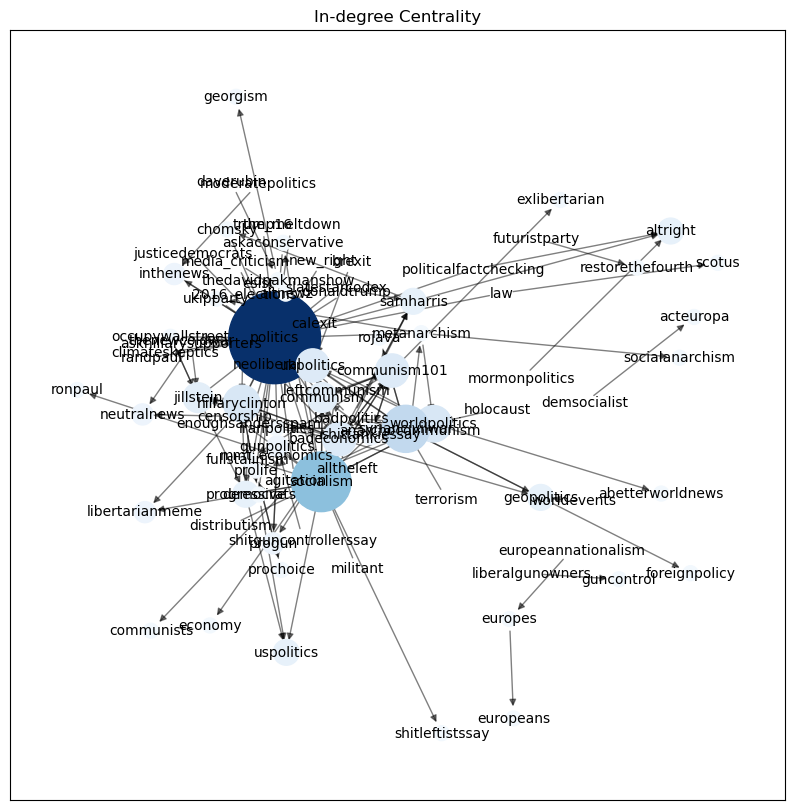

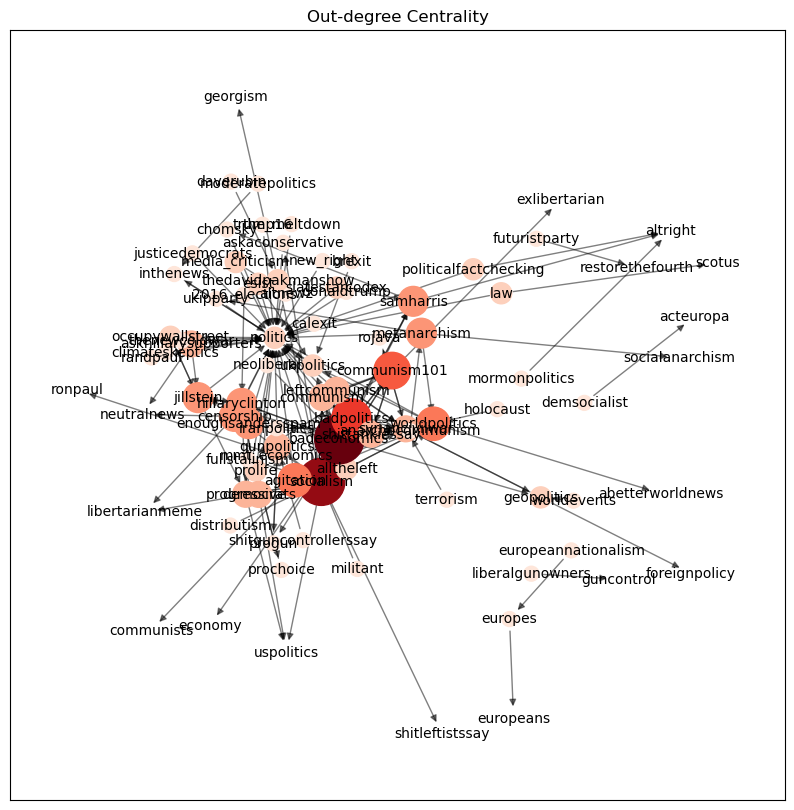

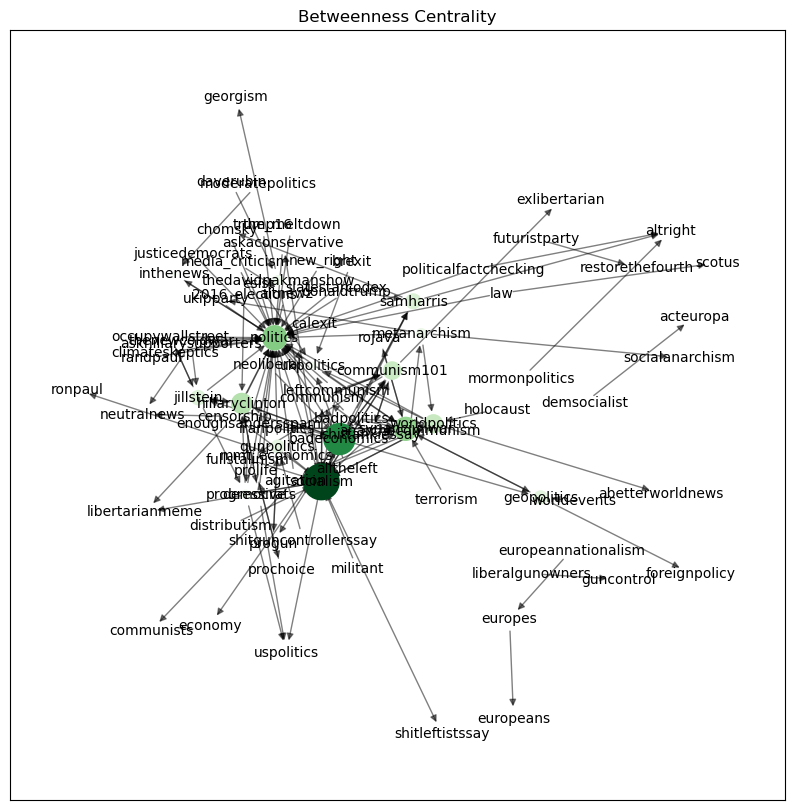

In [ ]:
import matplotlib.pyplot as plt

# Set node sizes based on centrality
node_size = [v * 10000 for v in in_degree_centrality.values()]  
node_color = [v for v in in_degree_centrality.values()] 

# Visualizing the graph with In-degree centrality
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.15, iterations=20)  
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.Blues)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('In-degree Centrality')
plt.show()

# Out-degree centrality visualization
node_size = [v * 10000 for v in out_degree_centrality.values()]
node_color = [v for v in out_degree_centrality.values()]
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.Reds)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('Out-degree Centrality')
plt.show()

# Betweenness centrality visualization
node_size = [v * 10000 for v in betweenness_centrality.values()]
node_color = [v for v in betweenness_centrality.values()]
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.Greens)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('Betweenness Centrality')
plt.show()


In [ ]:
betweenness = nx.betweenness_centrality(G_undirected, weight="count")
top_betweenness_nodes = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 nodes by betweenness centrality:", top_betweenness_nodes)


Top 10 nodes by betweenness centrality: [('politics', 0.3986354552513333), ('socialism', 0.24267427010009202), ('syriancivilwar', 0.14926447813376437), ('badeconomics', 0.1332124081923601), ('agitation', 0.1185762231471935), ('worldpolitics', 0.11262882770501054), ('badpolitics', 0.0934106405638082), ('samharris', 0.07697839895113351), ('metanarchism', 0.05934242181234964), ('geopolitics', 0.03982892274792836)]


In [ ]:
graph_density = nx.density(G_undirected)
print(f"Graph Density: {graph_density}")

for community, nodes in communities.items():
    subgraph = G_undirected.subgraph(nodes)
    community_density = nx.density(subgraph)
    print(f"Community {community} Density: {community_density}")


Graph Density: 0.035788923719958204
Community 0 Density: 0.25757575757575757
Community 1 Density: 1.0
Community 2 Density: 0.10541310541310542
Community 4 Density: 0.13450292397660818
Community 5 Density: 1.0
Community 7 Density: 1.0
Community 8 Density: 0.6666666666666666
Community 6 Density: 0.6666666666666666
Community 11 Density: 1.0
Community 12 Density: 0.3333333333333333
Community 13 Density: 0.6666666666666666
Community 10 Density: 1.0
Community 3 Density: 1.0
Community 9 Density: 0.6666666666666666


In [ ]:
edge_overlap = defaultdict(int)

for node in G_undirected.nodes():
    community = partition[node]
    for neighbor in G_undirected.neighbors(node):
        neighbor_community = partition[neighbor]
        if community != neighbor_community:
            edge_overlap[(community, neighbor_community)] += 1

print("Edge Overlap Between Communities:", dict(edge_overlap))


Edge Overlap Between Communities: {(0, 4): 4, (0, 2): 10, (0, 8): 1, (0, 12): 1, (0, 9): 1, (2, 0): 10, (2, 4): 11, (2, 5): 1, (2, 8): 2, (2, 6): 1, (2, 11): 1, (2, 12): 5, (4, 2): 11, (4, 0): 4, (4, 6): 2, (4, 12): 1, (5, 2): 1, (8, 2): 2, (8, 0): 1, (6, 2): 1, (6, 4): 2, (11, 2): 1, (12, 2): 5, (12, 4): 1, (12, 0): 1, (9, 0): 1}


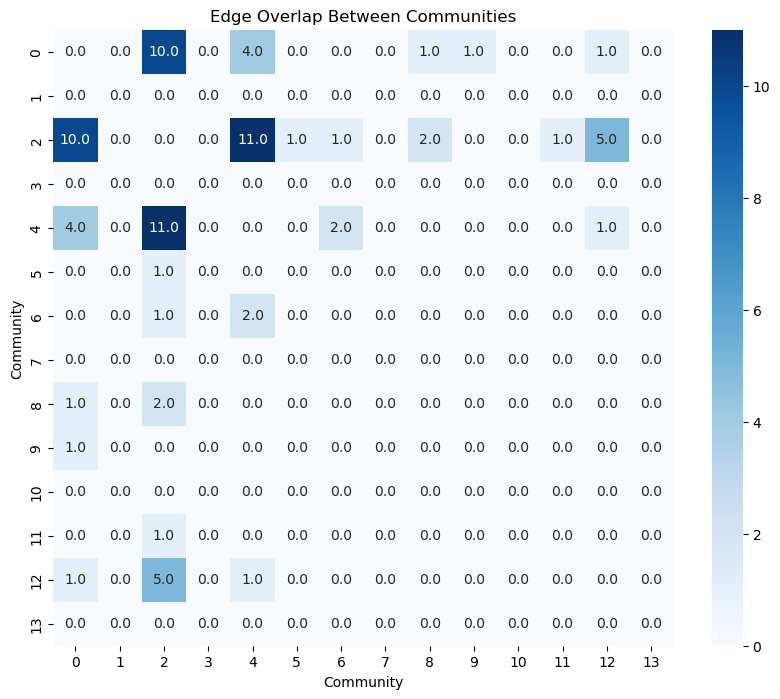

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a dictionary of community pairs and their overlap
max_community = max(partition.values()) + 1  

# Create an empty overlap matrix
overlap_matrix = np.zeros((max_community, max_community))

# Populate the matrix with the edge overlap data
for (community1, community2), overlap_count in edge_overlap.items():
    overlap_matrix[community1, community2] = overlap_count
    overlap_matrix[community2, community1] = overlap_count  

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=range(max_community), yticklabels=range(max_community))
plt.title("Edge Overlap Between Communities")
plt.xlabel("Community")
plt.ylabel("Community")
plt.show()


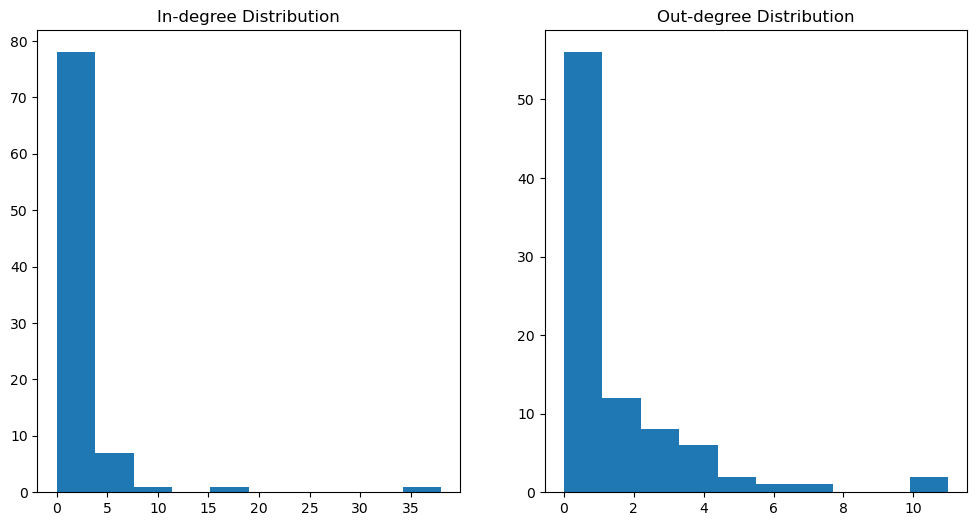

In [ ]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Plot In-degree and Out-degree distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(in_degrees.values())
plt.title("In-degree Distribution")

plt.subplot(1, 2, 2)
plt.hist(out_degrees.values())
plt.title("Out-degree Distribution")
plt.show()
